## Depth Estimation using DPT

### Global Imports

In [1]:
import tensorflow as tf
import torch
import time
import cv2
import numpy as np
import seaborn as sns
import keras
import matplotlib.pyplot as plt
import pandas as pd

from transformers import logging
from tensorflow import keras
from ipyfilechooser import FileChooser
from transformers import DPTImageProcessor, DPTForDepthEstimation
from PIL import Image
from scipy.io import loadmat

#custom imports
from model import compare_depth_estimation
from baseline import baseline_mean_shift_third
from constants import DATASET_FOLDER, EDEN_RGB_DIR, EDEN_DEPTH_DIR, RESULT_FOLDER
from datamaker import create_depth_data_csv

#### Configurations

In [2]:
tf.get_logger().setLevel('ERROR')
logging.set_verbosity_error()

#### Choose the test image

In [3]:
fc = FileChooser(DATASET_FOLDER)
display(fc)

FileChooser(path='C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset', filename='', title='', show_hidden=False…

#### Run DPT on the selected image

Note: this code will download the model file 

In [10]:
image = Image.open(fc.selected)

processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

# prepare image for the model
inputs = processor(images=image, return_tensors="pt")

#start time
start = time.time()
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth
#end time
end = time.time()

print("Time Taken: " + str(end - start))

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

Time Taken: 3.8559000492095947


#### Convert Images and Depth map to approriate format

In [11]:
#convert depth_inverted to PIL Image object
depth_inverted = Image.fromarray(np.invert(depth))

# assuming `image` is a PIL Image object, convert it to a numpy array
image = np.array(image)

#### Get Sky Segemenation Mask from Baseline

In [12]:
# apply mean shift algorithm
sky_mask_baseline, _, _ = baseline_mean_shift_third(image)

#### Get Sky Segmentation Mask from Model

In [13]:
model = keras.models.load_model("models/model_30000_5_optimized.h5")
#model = keras.models.load_model("models/model_transfer_1.h5")

sns.set_style("white")
sns.set_context("paper", font_scale=1)

image_model = tf.io.read_file(fc.selected)
image_model = tf.image.decode_jpeg(image_model, channels=3)

#get the shape of the image
original_shape = image_model.shape

image_model = tf.image.resize(image_model, [256, 256], method='nearest')
image_model = tf.image.convert_image_dtype(image_model, tf.float32)
image_model = tf.expand_dims(image_model, axis=0)

#reshape the prediction to the original shape
prediction = model.predict(image_model)
prediction = tf.image.resize(prediction, [original_shape[0], original_shape[1]], method='nearest')

#make a mask from the prediction where the value of the element is greater than 0.5 is 1 and 0 otherwise
sky_mask_model = np.where(prediction[0] > 0.6, 1, 0)
sky_mask_model = sky_mask_model.reshape(original_shape[0], original_shape[1])

1/1 [==============================] - 1s 1s/step


#### Mask the Depth Image using both masks

In [14]:
#assuming `mask` and `depth_inverted` are defined, use mask on the depth image
depth_masked_model = np.ma.masked_array(depth_inverted, mask=sky_mask_model)

#assuming `mask` and `depth_inverted` are defined, use mask on the depth image
depth_masked_baseline = np.ma.masked_array(depth_inverted, mask=sky_mask_baseline)

#### Display All Images

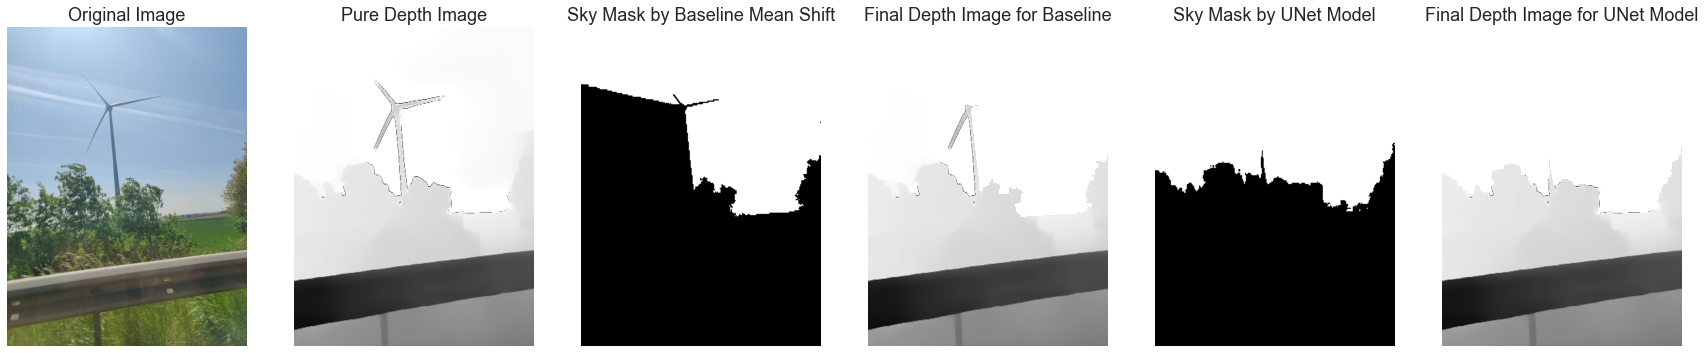

In [15]:
# Create a figure with 1 row and 6 columns
fig, axs = plt.subplots(1, 6, figsize=(30, 6))

# Plot the original image
axs[0].imshow(image)
axs[0].set_title('Original Image', fontsize=18)
axs[0].axis('off')

# Plot the depth-inverted image
axs[1].imshow(depth_inverted, cmap='gray')
axs[1].set_title('Pure Depth Image', fontsize=18)
axs[1].axis('off')

# Plot the sky mask
axs[2].imshow(sky_mask_baseline, cmap='gray')
axs[2].set_title('Sky Mask by Baseline Mean Shift', fontsize=18)
axs[2].axis('off')

# Plot the depth-masked image
axs[3].imshow(depth_masked_baseline, cmap='gray')
axs[3].set_title('Final Depth Image for Baseline', fontsize=18)
axs[3].axis('off')

# Plot the sky mask
axs[4].imshow(sky_mask_model, cmap='gray')
axs[4].set_title('Sky Mask by UNet Model', fontsize=18)
axs[4].axis('off')

# Plot the depth-masked image
axs[5].imshow(depth_masked_model, cmap='gray')
axs[5].set_title('Final Depth Image for UNet Model', fontsize=18)
axs[5].axis('off')

# Add a title to the figure
#fig.suptitle('Final Relative Depth Occlusion Map', fontsize=23)

# Show the plot
plt.show()

### Evaluation on EDEN Dataset

##### Example of EDEN Dataset

Maximum value of depth: 12.48830795288086
Minimum value of depth: 0.0


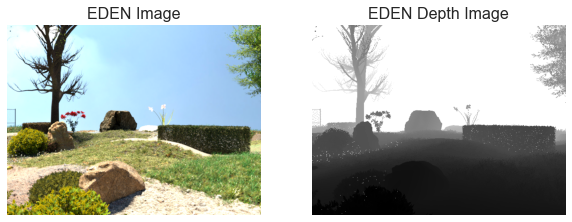

In [16]:
# Load the .mat file for depth and .png file for EDEN image
mat_data = loadmat(EDEN_DEPTH_DIR + "\\0001\\clear\\A_0002_L.mat")
eden_image = plt.imread(EDEN_RGB_DIR + "\\0001\\clear\\A_0002_L.png")

# Access the data
depth_data = mat_data['Depth']

# Print the maximum and minimum value of the data
print(f"Maximum value of depth: {depth_data.max()}")
print(f"Minimum value of depth: {depth_data.min()}")

#normalize the values in depth_data between 0 and 1
depth_data = depth_data / (depth_data.max())

#changes the values where the depth is exactly 0.0 to 1.0
depth_data[depth_data == 0.0] = 1.0

depth_data_squeezed = tf.squeeze(depth_data)

# plot eden_image and depth_data side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(eden_image)
axs[0].set_title('EDEN Image', fontsize=16)
axs[0].axis('off')
axs[1].imshow(depth_data, cmap='gray')
axs[1].set_title('EDEN Depth Image', fontsize=16)
axs[1].axis('off')
plt.show()

#### Dataset Creation Function (Only Run Once)

In [2]:
#create_depth_data_csv()

#### Evaluation Function (Use pre-exisitng data shipped with the repo, this function may take 24 hours to run)

In [ ]:
#compare_depth_estimation()

#### Read Evaluation Results

In [18]:
df = pd.read_csv(RESULT_FOLDER + "dpt_evaluation.csv")

### Compute Mean, Median and SD of all models

In [19]:
# calculate mean, median, and standard deviation of rmse_inverted, rmse_baseline, and rmse_unet
rmse_inverted_mean = df['rmse_inverted'].mean()
rmse_inverted_median = df['rmse_inverted'].median()
rmse_inverted_std = df['rmse_inverted'].std()

rmse_baseline_mean = df['rmse_baseline'].mean()
rmse_baseline_median = df['rmse_baseline'].median()
rmse_baseline_std = df['rmse_baseline'].std()

rmse_unet_mean = df['rmse_model'].mean()
rmse_unet_median = df['rmse_model'].median()
rmse_unet_std = df['rmse_model'].std()

In [20]:
# print results
print('RMSE DPT:')
print(f'Mean: {rmse_inverted_mean:.4f}')
print(f'Median: {rmse_inverted_median:.4f}')
print(f'Standard Deviation: {rmse_inverted_std:.4f}\n')

print('RMSE Baseline:')
print(f'Mean: {rmse_baseline_mean:.4f}')
print(f'Median: {rmse_baseline_median:.4f}')
print(f'Standard Deviation: {rmse_baseline_std:.4f}\n')

print('RMSE UNet:')
print(f'Mean: {rmse_unet_mean:.4f}')
print(f'Median: {rmse_unet_median:.4f}')
print(f'Standard Deviation: {rmse_unet_std:.4f}\n')

RMSE DPT:
Mean: 0.1929
Median: 0.1864
Standard Deviation: 0.0716

RMSE Baseline:
Mean: 0.1862
Median: 0.1801
Standard Deviation: 0.0723

RMSE UNet:
Mean: 0.1892
Median: 0.1825
Standard Deviation: 0.0709



### Compute the difference in RMSE for all models

In [21]:
# calculate mean, median, and standard deviation difference between rmse_inverted and rmse_baseline, and rmse_inverted and rmse_unet
diff_inverted_baseline = df['rmse_inverted'] - df['rmse_baseline']
diff_inverted_unet = df['rmse_inverted'] - df['rmse_model']

diff_inverted_baseline_mean = diff_inverted_baseline.mean()
diff_inverted_baseline_median = diff_inverted_baseline.median()
diff_inverted_baseline_std = diff_inverted_baseline.std()

diff_inverted_unet_mean = diff_inverted_unet.mean()
diff_inverted_unet_median = diff_inverted_unet.median()
diff_inverted_unet_std = diff_inverted_unet.std()

In [22]:
print('Difference between RMSE DPT and RMSE Baseline:')
print(f'Mean: {diff_inverted_baseline_mean:.4f}')
print(f'Median: {diff_inverted_baseline_median:.4f}')
print(f'Standard Deviation: {diff_inverted_baseline_std:.4f}\n')

print('Difference between RMSE DPT and RMSE UNet:')
print(f'Mean: {diff_inverted_unet_mean:.4f}')
print(f'Median: {diff_inverted_unet_median:.4f}')
print(f'Standard Deviation: {diff_inverted_unet_std:.4f}\n')

Difference between RMSE DPT and RMSE Baseline:
Mean: 0.0067
Median: 0.0039
Standard Deviation: 0.0134

Difference between RMSE DPT and RMSE UNet:
Mean: 0.0037
Median: 0.0027
Standard Deviation: 0.0152

